In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from env import get_db_url

In [2]:
query = """
SELECT  bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet AS sqft, taxvaluedollarcnt AS tax_value 
FROM properties_2017
JOIN predictions_2017 USING (id)
JOIN propertylandusetype USING (propertylandusetypeid)
WHERE (transactiondate  >='2017-05-01' AND transactiondate <= '2017-06-30') AND propertylandusetypeid = '261'
AND taxvaluedollarcnt <= 1000000;
"""
df = pd.read_sql(query, get_db_url("zillow"))
df.head(3)

,bathroomcnt,bedroomcnt,sqft,tax_value
0,2.0,4.0,1604.0,498347.0
1,3.0,3.0,2384.0,549917.0
2,2.0,3.0,1574.0,235272.0


In [3]:
df.shape

(14860, 4)

In [4]:
df.dtypes

bathroomcnt    float64
bedroomcnt     float64
sqft           float64
tax_value      float64
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14860 entries, 0 to 14859
Data columns (total 4 columns):
bathroomcnt    14860 non-null float64
bedroomcnt     14860 non-null float64
sqft           14828 non-null float64
tax_value      14860 non-null float64
dtypes: float64(4)
memory usage: 464.5 KB


In [6]:
df = df.dropna()

In [7]:
df.head()

,bathroomcnt,bedroomcnt,sqft,tax_value
0,2.0,4.0,1604.0,498347.0
1,3.0,3.0,2384.0,549917.0
2,2.0,3.0,1574.0,235272.0
3,2.0,2.0,1619.0,340000.0
4,2.0,4.0,1721.0,629951.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14828 entries, 0 to 14859
Data columns (total 4 columns):
bathroomcnt    14828 non-null float64
bedroomcnt     14828 non-null float64
sqft           14828 non-null float64
tax_value      14828 non-null float64
dtypes: float64(4)
memory usage: 579.2 KB


In [9]:
import split_scale

In [10]:
train, test = split_scale.split_my_data(df)

In [11]:
train.head()

,bathroomcnt,bedroomcnt,sqft,tax_value
6811,1.5,3.0,1127.0,493751.0
9172,3.0,5.0,2865.0,416153.0
8238,3.5,4.0,3677.0,855441.0
10832,2.0,4.0,2280.0,635561.0
3144,1.0,2.0,1344.0,187337.0


In [12]:
print(train.shape); print(test.shape)

(11862, 4)
(2966, 4)


In [13]:
scaler, train, test = split_scale.standard_scaler(train, test)

In [14]:
train.head(3)

,bathroomcnt,bedroomcnt,sqft,tax_value
6811,-0.694525,-0.195229,-0.818038,0.719736
9172,1.133129,2.031511,1.724257,0.365046
8238,1.742347,0.918141,2.912026,2.372972


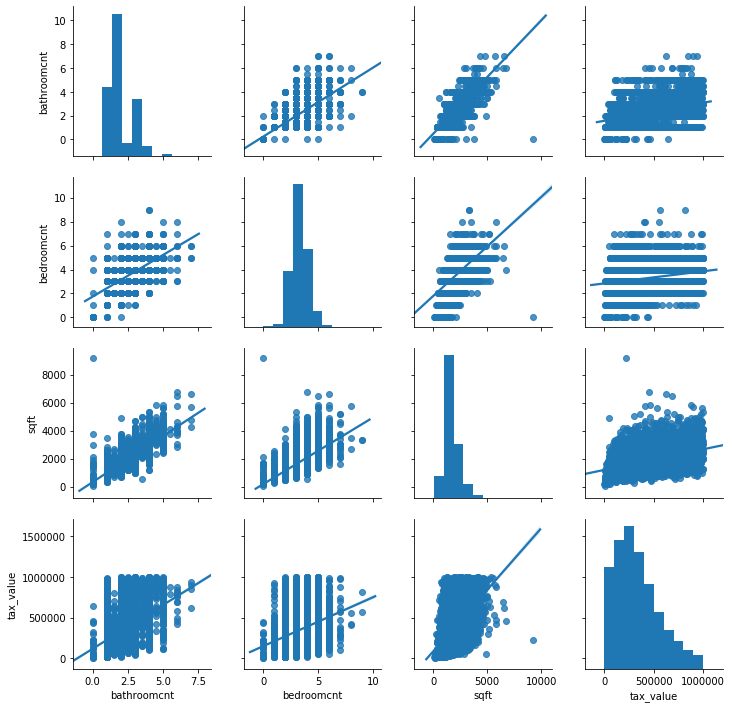

In [15]:
sns.pairplot(df, kind="reg")
plt.show()

(0, 4)

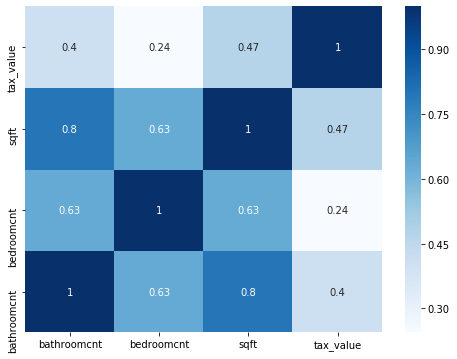

In [16]:
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(), cmap='Blues', annot=True)
plt.ylim(0, 4)

$H_0$: There is a linear relationship between sqft and tax_value.

$H_a$: There is no linear relationship between sqft and tax_value.

In [17]:
from math import sqrt
from scipy import stats

In [18]:
alpha = 0.01
r, p = stats.pearsonr(train.sqft, train.tax_value)
r, p

(0.47365229164371503, 0.0)

In [19]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis


In [20]:
alpha = 0.01
r, p = stats.pearsonr(train.bathroomcnt, train.tax_value)
r, p

(0.40390654767751577, 0.0)

In [21]:
alpha = 0.01
r, p = stats.pearsonr(train.bedroomcnt, train.tax_value)
r, p

(0.24415975982524896, 1.5211415406458222e-160)

In [22]:
alpha = 0.01
r, p = stats.pearsonr(train.bedroomcnt, train.sqft)
r, p

(0.6319442677506852, 0.0)

In [23]:
alpha = 0.01
r, p = stats.pearsonr(train.bedroomcnt, train.bathroomcnt)
r, p

(0.6341264286925882, 0.0)

In [24]:
predictions = pd.DataFrame({
    'actual_tax_value': train.tax_value
})
predictions.head()

,actual_tax_value
6811,0.719736
9172,0.365046
8238,2.372972
10832,1.367930
3144,-0.680842


In [25]:
from sklearn.metrics import mean_squared_error, explained_variance_score
#from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import sklearn.linear_model
import warnings
warnings.filterwarnings("ignore")
import split_scale

In [26]:
X = train[['bathroomcnt','bedroomcnt']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bath&bed_lm'] = lm.predict(X)

In [27]:
predictions.head(3)

,actual_tax_value,bath&bed_lm
6811,0.719736,-0.285431
9172,0.365046,0.431396
8238,2.372972,0.707483


In [28]:
X = train[['bathroomcnt','bedroomcnt','sqft']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bath&bed&sqft_lm'] = lm.predict(X)

In [29]:
predictions.head(3)

,actual_tax_value,bath&bed_lm,bath&bed&sqft_lm
6811,0.719736,-0.285431,-0.429350
9172,0.365046,0.431396,0.680158
8238,2.372972,0.707483,1.420809


In [30]:
predictions['baseline'] = predictions.actual_tax_value.mean()
predictions.head(3)

,actual_tax_value,bath&bed_lm,bath&bed&sqft_lm,baseline
6811,0.719736,-0.285431,-0.429350,-1.263578e-16
9172,0.365046,0.431396,0.680158,-1.263578e-16
8238,2.372972,0.707483,1.420809,-1.263578e-16


In [31]:
X = train[['bathroomcnt']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bath_lm'] = lm.predict(X)

In [32]:
X = train[['bedroomcnt',]]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bed&sqft_lm'] = lm.predict(X)

In [33]:
X = train[['sqft']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['sqft_lm'] = lm.predict(X)

In [34]:
X = train[['bedroomcnt','sqft']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bed&sqft_lm'] = lm.predict(X)

In [35]:
X = train[['bathroomcnt','sqft']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bath&sqft_lm'] = lm.predict(X)

In [36]:
predictions.apply(lambda col: sklearn.metrics.mean_squared_error(predictions.actual_tax_value, col))

actual_tax_value    0.000000
bath&bed_lm         0.836620
bath&bed&sqft_lm    0.766404
baseline            1.000000
bath_lm             0.836860
bed&sqft_lm         0.770588
sqft_lm             0.775654
bath&sqft_lm        0.773855
dtype: float64

In [37]:
def select_rfe(X, y, k):
    lm = sklearn.linear_model.LinearRegression()
    rfe = sklearn.feature_selection.RFE(lm, k)
    rfe.fit(X, y)
    return X.columns[rfe.support_]

In [38]:
X = train[['bathroomcnt','bedroomcnt','sqft']]
y = train.tax_value
k = 2
select_rfe(X, y, k)

Index(['bedroomcnt', 'sqft'], dtype='object')

In [39]:
def select_kbest(X, y, k):
    kbest = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression, k)
    kbest.fit(X, y)
    return X.columns[kbest.get_support()]

In [40]:
select_kbest(X, y, k)

Index(['bathroomcnt', 'sqft'], dtype='object')

In [41]:
# 2. Fit a linear regression model (ordinary least squares) and compute yhat, predictions of tip using total_bill.
from statsmodels.formula.api import ols
model = ols('tax_value ~ bathroomcnt', df).fit()
df['yhat'] = model.predict(df.bathroomcnt)

In [42]:
df.head()

,bathroomcnt,bedroomcnt,sqft,tax_value,yhat
0,2.0,4.0,1604.0,498347.0,330634.167754
1,3.0,3.0,2384.0,549917.0,438851.523166
2,2.0,3.0,1574.0,235272.0,330634.167754
3,2.0,2.0,1619.0,340000.0,330634.167754
4,2.0,4.0,1721.0,629951.0,330634.167754


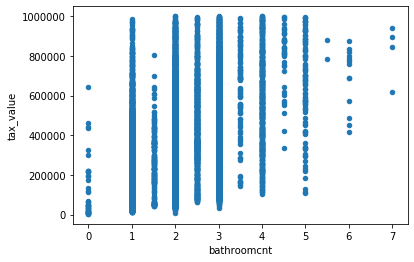

In [43]:
df.plot.scatter(y='tax_value', x='bathroomcnt')

In [44]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              tax_value   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     2907.
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:33:00   Log-Likelihood:            -2.0209e+05
No. Observations:               14828   AIC:                         4.042e+05
Df Residuals:                   14826   BIC:                         4.042e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.142e+05   4473.471     25.528      0.000    1.05e+05    1.23e+05
bathroomcnt  1.082e+05   2007.006     53.920      0.000    1.04e+05    1.12e+05
==============================================================================
Omnibus:                      958.790   Durbin-Watson:                   1.642
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1154.861
Skew:                           0.680   Prob(JB):                    1.68e-251
Kurtosis:                       3.137   Cond. No.                         7.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""